In [1]:
import warnings
warnings.filterwarnings('ignore')

# import preprocessing function
from helpers.preprocessing import *

# import dependencies
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from config import db_password
import matplotlib.pyplot as plt

# import machine learning dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import multiprocessing

# import neural network dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

## Read the Data from SQL

In [2]:
X, y = preprocessing('fall')
X.head()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
0,8,-117.25760,32.80751,6,4,5.0,4.76,4.75,4.55,4.91,4.91,4.80,4.76,2.0,0,1,0,0,0,0
1,1,-117.21931,32.74217,54,1,3.0,4.33,4.35,4.22,4.72,4.79,4.61,4.40,1.0,0,0,0,0,1,0
2,7,-117.25416,32.79783,0,6,2.0,4.75,4.79,4.55,4.88,4.81,4.89,4.69,2.5,0,1,0,0,0,0
3,8,-117.25728,32.80751,44,6,2.0,4.72,4.77,4.73,4.88,4.81,4.78,4.65,2.0,0,1,0,0,0,0
4,3,-117.26856,32.81301,42,5,2.0,4.94,4.92,4.95,4.97,4.98,4.97,4.89,1.0,0,1,0,0,0,0


In [3]:
log_y = np.log10(y)
log_y.describe()

count    13622.000000
mean         2.266935
std          0.314715
min          1.000000
25%          2.060698
50%          2.255273
75%          2.477121
max          2.999565
Name: price, dtype: float64

# Split the Data into Training and Testing

In [4]:
X.describe()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
count,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000,13622.000000
mean,4.648510,-117.171980,32.761744,48.779988,6.793716,52.308031,4.749905,4.797906,4.757913,4.860079,4.845454,4.830098,4.693690,1.519637,0.006313,0.391572,0.429893,0.003083,0.163412,0.005726
std,2.904256,0.074840,0.095936,31.395263,19.571315,211.497464,0.384822,0.336678,0.355884,0.303925,0.317569,0.287505,0.363389,0.837703,0.079208,0.488120,0.495079,0.055443,0.369755,0.075456
min,1.000000,-117.282580,32.519860,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,-117.247197,32.718390,19.000000,1.000000,1.000000,4.710000,4.780000,4.720000,4.860000,4.840000,4.820000,4.650000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,-117.164614,32.754423,55.000000,2.000000,4.000000,4.820000,4.870000,4.830000,4.940000,4.930000,4.900000,4.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,-117.127852,32.797500,77.000000,4.000000,17.000000,4.950000,4.980000,4.960000,5.000000,5.000000,5.000000,4.890000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,16.000000,-116.896560,33.125690,90.000000,999.000000,2641.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,27.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, log_y, random_state=10)

In [6]:
y_train.describe()

count    10216.000000
mean         2.264047
std          0.315034
min          1.000000
25%          2.060698
50%          2.252853
75%          2.477121
max          2.999565
Name: price, dtype: float64

In [7]:
y_test.describe()

count    3406.000000
mean        2.275600
std         0.313641
min         1.204120
25%         2.071882
50%         2.267172
75%         2.487138
max         2.999565
Name: price, dtype: float64

In [8]:
# scale the X data
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## XGBoost Regression Model

In [9]:
# create a XGBooster regression model and use GridSearch to test various fits
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[19:11:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:11:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [10]:
# show results of best model in grid
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7773948643518375
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [11]:
# use xgb_grid model to predict prices for testing and training groups
pred_test = xgb_grid.best_estimator_.predict(X_test)
pred_train = xgb_grid.best_estimator_.predict(X_train)

# mean squared error isn't meaningful with logarithmic data
print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**pred_train),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**pred_test),4))

# mean absolute error as sqrt of MSE
print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**pred_train)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**pred_test)**0.5,4))

# print r2 values for training and testing models
print("\nTraining r2:", round(r2_score(y_train, pred_train),4))
print("Testing r2:", round(r2_score(y_test, pred_test),4))


Training MSE: 6150.7514
Testing MSE: 9725.4667

Training MAE: 78.4267
Testing MAE: 98.6178

Training r2: 0.8758
Testing r2: 0.7944


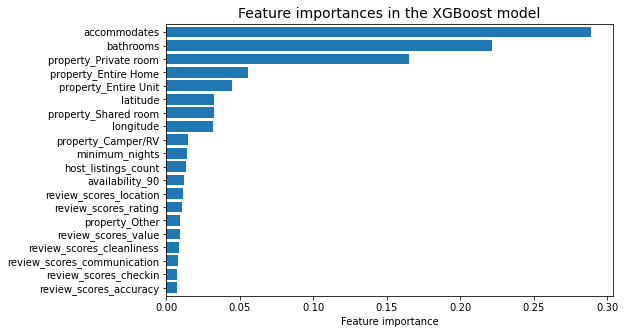

In [27]:
# plot the importance of features in the xgb_grid model
ft_weights_xgb_grid = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_grid.sort_values('weight', inplace=True)

plt.figure(figsize=(8,5))
plt.barh(ft_weights_xgb_grid.index, ft_weights_xgb_grid.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [13]:
# a simpler XGBooster model, without the grid search

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_training_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

In [14]:
# print the r2 scores for the simple xgb_model
print("\nTraining r2:", round(r2_score(y_train, xgb_training_preds),4))
print("Testing r2:", round(r2_score(y_test, xgb_test_preds),4))


Training r2: 0.9164
Testing r2: 0.7805


## Neural Network

In [15]:
size = X_train_scaled.shape[1]

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = size
hidden_nodes_layer1 = size * 3
hidden_nodes_layer2 = size * 6
hidden_nodes_layer3 = size * 6

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1260      
                                                                 
 dense_1 (Dense)             (None, 120)               7320      
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 1)                 121       
                                                                 
Total params: 23,221
Trainable params: 23,221
Non-trainable params: 0
_________________________________________________________________


In [17]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics = ['mean_squared_error'])

In [18]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
320/320 [==============================] - 1s 1ms/step - loss: 0.7126 - mean_squared_error: 79.2884
Epoch 2/100
320/320 [==============================] - 0s 1ms/step - loss: 0.1652 - mean_squared_error: 0.0480
Epoch 3/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1591 - mean_squared_error: 0.0445
Epoch 4/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1996 - mean_squared_error: 0.3996
Epoch 5/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1964 - mean_squared_error: 0.0631
Epoch 6/100
320/320 [==============================] - 1s 2ms/step - loss: 0.2016 - mean_squared_error: 0.0667
Epoch 7/100
320/320 [==============================] - 1s 2ms/step - loss: 0.2016 - mean_squared_error: 0.0667
Epoch 8/100
320/320 [==============================] - 1s 2ms/step - loss: 0.2012 - mean_squared_error: 0.0661
Epoch 9/100
320/320 [==============================] - 1s 2ms/step - loss: 0.2058 - mean_squared_error: 0.0690


320/320 [==============================] - 1s 2ms/step - loss: 0.1958 - mean_squared_error: 0.0618
Epoch 75/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1955 - mean_squared_error: 0.0618
Epoch 76/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1958 - mean_squared_error: 0.0620
Epoch 77/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1958 - mean_squared_error: 0.0620
Epoch 78/100
320/320 [==============================] - 1s 2ms/step - loss: 0.2001 - mean_squared_error: 0.0648
Epoch 79/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1966 - mean_squared_error: 0.0624
Epoch 80/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1976 - mean_squared_error: 0.0633
Epoch 81/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1973 - mean_squared_error: 0.0628
Epoch 82/100
320/320 [==============================] - 1s 2ms/step - loss: 0.1951 - mean_squared_error: 0.0615
Epoch

In [19]:
# Evaluate the mean absolute error of the  model using the test data
nn_train_preds = nn.predict(X_train_scaled)
nn_test_preds = nn.predict(X_test_scaled)

print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**nn_train_preds),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**nn_test_preds),4))

print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**nn_train_preds)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**nn_test_preds)**0.5,4))

print("\nTraining r2:", round(r2_score(y_train, nn_train_preds),4))
print("Testing r2:", round(r2_score(y_test, nn_test_preds),4))

107/107 [==============================] - 0s 1ms/step

Training MSE: 25844.8116
Testing MSE: 26610.0658

Training MAE: 160.7632
Testing MAE: 163.1259

Training r2: 0.3996
Testing r2: 0.4011
